# RGCN

Predict forest harvest volumes (posek_iglavcev, posek_listavcev) for Sestoj (forest stands) using a heterogeneous relational graph neural network (RGCN) built from a SQLite forest database.

### Install

In [1]:
pip install numpy pandas torch torch-geometric scikit-learn sentence-transformers

Note: you may need to restart the kernel to use updated packages.


### Import

In [ ]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam 
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, RGCNConv, LayerNorm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sentence_transformers import SentenceTransformer 
import warnings 
warnings.filterwarnings("ignore") 

⚠️ Important: Before running the code also run ../../datasets/razdeli.sql and save the database 

### Setup

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
EMBEDDING_MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2" 
HIDDEN_DIM = 128 # 256 cuda crash OOM
LR = 0.001 
EPOCHS = 2500 
DROPOUT = 0.2 
TARGETS = ["posek_iglavcev", "posek_listavcev"] 

### Graph data preparation

In [3]:
def normalize_text(x): 
    """
    Clean and normalize raw text input.

    - Handles NaN values safely (returns empty string)
    - Converts text to lowercase
    - Strips leading / trailing whitespace

    Input:
        x (Any): String or NaN

    Output:
        str: Normalized text string
    """
    if pd.isna(x): 
        return "" 
    return str(x).lower().strip() 

def embed_text(model, series): 
    """
    Embed a pandas series of text into dense numeric vectors
    using a SentenceTransformer.

    Assumptions:
        - series is a pandas Series
        - model outputs embeddings of fixed dimension (384)

    Steps:
        1. Replace NaNs with empty strings
        2. Convert all values to strings
        3. Normalize text with function normalize_text
        4. Encode text into embeddings

    Input:
        model (SentenceTransformer): Loaded embedding model
        series (pd.Series): Text column

    Output:
        np.ndarray of shape (n_rows, embedding_dim)
    """
    return model.encode(series.fillna("").astype(str).map(normalize_text).tolist(), show_progress_bar=False) 

def standardize(df, cols): 
    """
    Standardize numeric columns using z-score normalization.

    Input:
        df (pd.DataFrame): DataFrame containing numeric features
        cols (List[str]): Columns to standardize

    Output:
        pd.DataFrame: Same DataFrame with standardized columns
    """
    scaler = StandardScaler()
    df[cols] = scaler.fit_transform(df[cols]) 
    return df 

def build_id_map(df: pd.DataFrame, pk: str): 
    """
    Map primary key values to contiguous integer node IDs.

    Required by PyTorch Geometric:
        - Node indices must be integers in [0, num_nodes)

    Assumptions:
        - pk column exists in df
        - Values uniquely identify rows

    Input:
        df (pd.DataFrame): Table containing node identifiers
        pk (str): Primary key column name

    Output:
        Dict[str, int]: Mapping from original ID -> node index
    """
    return {str(v): i for i, v in enumerate(df[pk].astype(str).values)} 

def build_edge_index(src_df, dst_map, src_pk, fk_col, src_map): 
    """
    Build PyTorch Geometric edge_index tensor from relational data.

    For each row:
        src node = src_map[src_pk]
        dst node = dst_map[fk_col]

    Rows with missing foreign keys are skipped.

    Assumptions:
        - src_df contains both src_pk and fk_col
        - src_map and dst_map are complete mappings

    Input:
        src_df (pd.DataFrame): Source table
        dst_map (Dict[str, int]): Destination node ID map
        src_pk (str): Source primary key column
        fk_col (str): Foreign key column
        src_map (Dict[str, int]): Source node ID map

    Output:
        torch.LongTensor of shape [2, num_edges]
    """
    src, dst = [], [] 
    for _, r in src_df.iterrows(): 
        fk = str(r[fk_col]) 
        if fk in dst_map: 
            src.append(src_map[str(r[src_pk])]) 
            dst.append(dst_map[fk]) 
    return torch.tensor([src, dst], dtype=torch.long) 


def calculate_metrics(y_true, y_pred): 
    """
    Compute standard regression metrics.

    Inputs:
        y_true (Tensor): Ground truth values
        y_pred (Tensor): Predicted values

    Output:
        Dict[str, float]: Dictionary containing R2, MAE, and RMSE
    """
    y_true, y_pred = y_true.cpu().numpy(), y_pred.cpu().numpy() 
    return { 
        "r2": r2_score(y_true, y_pred), 
        "mae": mean_absolute_error(y_true, y_pred), 
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred)) 
    } 

### Build a graph

In [5]:
def load_and_build_graph(db_path): 
    """
    Load relational data from SQLite database and construct
    a PyTorch Geometric HeteroData graph.

    This function:
        - Loads all tables into pandas DataFrames
        - Builds node features (text embeddings + numeric features)
        - Constructs heterogeneous edges
        - Creates train / val / test masks for Sestoj nodes

    Input:
        db_path (str): Path to SQLite database

    Output:
        HeteroData: Fully constructed heterogeneous graph
    """
    conn = sqlite3.connect(db_path) 
    tables = {t: pd.read_sql(f"SELECT * FROM {t}", conn) for t in ["Enota", "Obmocje", "Revir", "Krajevna_Enota", "Relief", "Tarife", "Odsek", "Sestoj", "Sestava_Gozda"]} 
    conn.close() 
    model = SentenceTransformer(EMBEDDING_MODEL_NAME) 
    data = HeteroData() 
    data["Enota"].x = torch.tensor(embed_text(model, tables["Enota"]["gge_naziv"])) 
    data["Obmocje"].x = torch.tensor(embed_text(model, tables["Obmocje"]["ggo_naziv"])) 
    data["Revir"].x = torch.tensor(embed_text(model, tables["Revir"]["revir_naziv"])) 
    data["Krajevna_Enota"].x = torch.tensor(embed_text(model, tables["Krajevna_Enota"]["ke_naziv"])) 
    data["Odsek"].x = torch.tensor(standardize(tables["Odsek"], ["povrsina", "gojitveni_razred_ggo", "gojitveni_razred_gge", "kategorija_gozd", "ohranjenost_gozda", "polozaj_pokrajine", "pozar_ogrozenost", "intenzivnost_gospodarjenja", "rastiscni_tip", "rastiscni_koeficient", "vezani_ogljik", "letni_ponor_ogljika"]).iloc[:, 5:].values, dtype=torch.float) 
    data["Relief"].x = torch.tensor(standardize(tables["Relief"], ["relief", "lega", "nagib", "s_nadmorska_visina", "z_nadmorska_visina", "kamnina", "delez_kamnitosti", "delez_skalovitosti", "odprtost", "odprt_gurs"]).iloc[:, 1:].values, dtype=torch.float) 
    data["Tarife"].x = torch.tensor(standardize(tables["Tarife"], tables["Tarife"].columns[1:].tolist()).iloc[:, 1:].values, dtype=torch.float) 
    data["Sestava_Gozda"].x = torch.tensor(standardize(tables["Sestava_Gozda"], tables["Sestava_Gozda"].columns[1:].tolist()).iloc[:, 1:].values, dtype=torch.float) 
    sestoj_feats = ["povrsina", "razvojna_faza", "gojitvena_smer", "zasnova", "sklep", "negovanost", "pomladek_ha", "pomladek_zasnova", "zaloga_iglavcev", "zaloga_listavcev", "zaloga_skupno"] 
    data["Sestoj"].x = torch.tensor(standardize(tables["Sestoj"], sestoj_feats).iloc[:, 3:14].values, dtype=torch.float) 
    data["Sestoj"].y = torch.tensor(tables["Sestoj"][TARGETS].values, dtype=torch.float) 
    ids = { 
        "Enota": build_id_map(tables["Enota"], "gge"), 
        "Obmocje": build_id_map(tables["Obmocje"], "ggo"), 
        "Revir": build_id_map(tables["Revir"], "revir"), 
        "Krajevna_Enota": build_id_map(tables["Krajevna_Enota"], "ke"), 
        "Odsek": build_id_map(tables["Odsek"], "odsek"), 
        "Sestoj": build_id_map(tables["Sestoj"], "sestoj"), 
        "Relief": build_id_map(tables["Relief"], "odsek"), 
        "Tarife": build_id_map(tables["Tarife"], "odsek"), 
        "Sestava_Gozda": build_id_map(tables["Sestava_Gozda"], "sestoj"), 
    } 
    data["Odsek", "in", "Obmocje"].edge_index = build_edge_index(tables["Odsek"], ids["Obmocje"], "odsek", "ggo", ids["Odsek"]) 
    data["Odsek", "in", "Enota"].edge_index = build_edge_index(tables["Odsek"], ids["Enota"], "odsek", "gge", ids["Odsek"]) 
    data["Odsek", "in", "Krajevna_Enota"].edge_index = build_edge_index(tables["Odsek"], ids["Krajevna_Enota"], "odsek", "ke", ids["Odsek"]) 
    data["Odsek", "in", "Revir"].edge_index = build_edge_index(tables["Odsek"], ids["Revir"], "odsek", "revir", ids["Odsek"]) 
    data["Sestoj", "part_of", "Odsek"].edge_index = build_edge_index(tables["Sestoj"], ids["Odsek"], "sestoj", "odsek", ids["Sestoj"]) 
    data["Relief", "describes", "Odsek"].edge_index = build_edge_index(tables["Relief"], ids["Odsek"], "odsek", "odsek", ids["Relief"]) 
    data["Tarife", "applies_to", "Odsek"].edge_index = build_edge_index(tables["Tarife"], ids["Odsek"], "odsek", "odsek", ids["Tarife"]) 
    data["Sestava_Gozda", "describes", "Sestoj"].edge_index = build_edge_index(tables["Sestava_Gozda"], ids["Sestoj"], "sestoj", "sestoj", ids["Sestava_Gozda"]) 
    num_nodes = data["Sestoj"].num_nodes 
    indices = torch.randperm(num_nodes) 
    train_size = int(0.8 * num_nodes) 
    val_size = int(0.1 * num_nodes) 
    data["Sestoj"].train_mask = torch.zeros(num_nodes, dtype=torch.bool) 
    data["Sestoj"].val_mask = torch.zeros(num_nodes, dtype=torch.bool) 
    data["Sestoj"].test_mask = torch.zeros(num_nodes, dtype=torch.bool) 
    data["Sestoj"].train_mask[indices[:train_size]] = True 
    data["Sestoj"].val_mask[indices[train_size:train_size+val_size]] = True 
    data["Sestoj"].test_mask[indices[train_size+val_size:]] = True 
    return data 

### Model inicialization

In [6]:
class RGCN(torch.nn.Module):
    """
    Two-layer Heterogeneous Relational Graph Convolutional Network (R-GCN).

    This model:
        - Projects all node types into a shared hidden space
        - Applies two stacked heterogeneous R-GCN layers
        - Predicts regression targets for "Sestoj" nodes only

    Assumptions:
        - Input graph is a PyG HeteroData object
        - All node types have feature matrices
        - Regression is performed on the "Sestoj" node type
    """
    def __init__(self, metadata, in_dims, hidden_channels, out_channels):
        """
        Initialize the heterogeneous R-GCN model.

        Inputs:
            metadata (Tuple[List[str], List[EdgeType]]):
                Output of data.metadata(), containing node and edge types
            in_dims (Dict[str, int]):
                Mapping from node type -> input feature dimension
            hidden_channels (int):
                Shared hidden dimension across all node types
            out_channels (int):
                Output dimension for regression (number of targets)

        Output:
            RGCN model instance
        """
        super().__init__()
        
        self.proj = nn.ModuleDict({
            node_type: nn.Linear(in_dim, hidden_channels)
            for node_type, in_dim in in_dims.items()
        })
        
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        
        num_layers = 2
        num_relations = len(metadata[1]) 
        
        for _ in range(num_layers):
            conv_dict = {}
            for i, edge_type in enumerate(metadata[1]):
                conv_dict[edge_type] = RGCNConv(
                    (hidden_channels, hidden_channels), 
                    hidden_channels, 
                    num_relations=num_relations
                )
            
            self.convs.append(HeteroConv(conv_dict, aggr='mean'))
            norm_dict = nn.ModuleDict({
                node_type: LayerNorm(hidden_channels, mode="node")
                for node_type in metadata[0]
            })
            self.norms.append(norm_dict)

        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        """
        Forward pass through the heterogeneous R-GCN.

        Inputs:
            x_dict (Dict[str, Tensor]):
                Node feature tensors keyed by node type
            edge_index_dict (Dict[EdgeType, Tensor]):
                Edge index tensors keyed by edge type

        Output:
            Tensor of shape [num_sestoj_nodes, out_channels]
        """
        x_dict = {
            node_type: F.relu(self.proj[node_type](x))
            for node_type, x in x_dict.items()
        }

        edge_type_dict = {}
        for i, edge_type in enumerate(edge_index_dict.keys()):
            edge_type_dict[edge_type] = torch.full(
                (edge_index_dict[edge_type].size(1),), i, 
                dtype=torch.long, device=next(iter(x_dict.values())).device
            )

        for conv, norm_dict in zip(self.convs, self.norms):
            new_x_dict = conv(x_dict, edge_index_dict, edge_type_dict)
            
            for node_type, x in new_x_dict.items():
                x = norm_dict[node_type](x)
                x = F.relu(x)
                x = F.dropout(x, p=0.2, training=self.training)
                x_dict[node_type] = x

        return self.lin(x_dict["Sestoj"])


### Training a model

In [7]:
def train_model(data): 
    """
    Train the R-GCN model on the heterogeneous forest graph.

    Training details:
        - Supervision only on "Sestoj" nodes
        - L1 loss (MAE) used for evaluation
        - Best model saved based on validation loss

    Input:
        data (HeteroData): Graph with features, edges, labels, and masks

    Output:
        RGCN: Trained model instance
    """
    data = data.to(DEVICE) 
    in_dims = { 
        node_type: data[node_type].x.shape[1] 
        for node_type in data.node_types
    } 
    model = RGCN(data.metadata(), in_dims, HIDDEN_DIM, 2).to(DEVICE) 
    optimizer = Adam(model.parameters(), lr=LR) 
    #criterion = nn.MSELoss() 
    criterion = nn.L1Loss()
    best_val_loss = float('inf') 
    for epoch in range(1, EPOCHS + 1): 
        model.train() 
        optimizer.zero_grad() 
        out = model(data.x_dict, data.edge_index_dict) 
        loss = criterion(out[data["Sestoj"].train_mask], data["Sestoj"].y[data["Sestoj"].train_mask]) 
        loss.backward() 
        optimizer.step() 
        model.eval() 
        with torch.no_grad(): 
            val_out = model(data.x_dict, data.edge_index_dict) 
            val_loss = criterion(val_out[data["Sestoj"].val_mask], data["Sestoj"].y[data["Sestoj"].val_mask]) 
            if epoch % 100 == 0: 
                metrics = calculate_metrics(data["Sestoj"].y[data["Sestoj"].val_mask], val_out[data["Sestoj"].val_mask]) 
                print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, R2: {metrics["r2"]:.4f}') 
                if val_loss < best_val_loss: 
                    best_val_loss = val_loss 
                    torch.save(model.state_dict(), 'best_forest_rgcn.pt')
    return model 

### Testing a model

In [8]:
def test_model(model, data): 
    """
    Evaluate the trained model on the test split.

    Steps:
        - Load best saved model
        - Run inference on test nodes
        - Clamp predictions to be non-negative
        - Print predictions and metrics

    Inputs:
        model (RGCN): Model instance
        data (HeteroData): Graph with test mask

    Output:
        None (prints results to stdout)
    """
    model.load_state_dict(torch.load('best_forest_rgcn.pt')) 
    model.eval() 
    with torch.no_grad(): 
        out = model(data.x_dict, data.edge_index_dict) 
        out = torch.clamp(out, min=0.0)
        y_true = data["Sestoj"].y[data["Sestoj"].test_mask]
        y_pred = out[data["Sestoj"].test_mask]

        metrics = calculate_metrics(y_true, y_pred) 

        print("\n--- Predictions vs Actual Values ---")
        #for i in range(y_true.size(0)):
        #    print(f"Actual: {y_true[i].cpu().numpy()}, Predicted: {y_pred[i].cpu().numpy()}")

        print("\n--- Final Test Metrics ---") 
        print(f"R2: {metrics['r2']:.4f}") 
        print(f"MAE: {metrics['mae']:.4f}") 
        print(f"MSE: {metrics['rmse']**2:.4f}") 
        print(f"RMSE: {metrics['rmse']:.4f}") 

### Running a model 

In [9]:
if __name__ == "__main__": 
    db_path = "../../datasets/forest_db.sqlite" 
    print("Building Graph...") 
    forest_graph = load_and_build_graph(db_path)
    print("Starting Training...") 
    trained_model = train_model(forest_graph) 
    test_model(trained_model, forest_graph)

Building Graph...
Starting Training...
Epoch: 100, Loss: 98.3246, Val Loss: 97.7988, R2: -0.1351
Epoch: 200, Loss: 92.7600, Val Loss: 92.1427, R2: -0.0983
Epoch: 300, Loss: 87.1848, Val Loss: 86.4360, R2: -0.0573
Epoch: 400, Loss: 81.9222, Val Loss: 81.0352, R2: -0.0134
Epoch: 500, Loss: 77.0443, Val Loss: 76.0706, R2: 0.0319
Epoch: 600, Loss: 72.7043, Val Loss: 71.5738, R2: 0.0768
Epoch: 700, Loss: 68.8295, Val Loss: 67.5459, R2: 0.1207
Epoch: 800, Loss: 65.3157, Val Loss: 63.9153, R2: 0.1622
Epoch: 900, Loss: 62.1715, Val Loss: 60.6218, R2: 0.2024
Epoch: 1000, Loss: 59.3544, Val Loss: 57.6975, R2: 0.2399
Epoch: 1100, Loss: 56.7743, Val Loss: 55.0169, R2: 0.2761
Epoch: 1200, Loss: 54.4695, Val Loss: 52.5826, R2: 0.3102
Epoch: 1300, Loss: 52.4371, Val Loss: 50.4354, R2: 0.3416
Epoch: 1400, Loss: 50.5238, Val Loss: 48.4842, R2: 0.3716
Epoch: 1500, Loss: 48.8357, Val Loss: 46.7625, R2: 0.3986
Epoch: 1600, Loss: 47.3239, Val Loss: 45.1894, R2: 0.4246
Epoch: 1700, Loss: 45.9102, Val Loss: 

### Visualisation

##### Comparison of model MAE using different aggregation methods

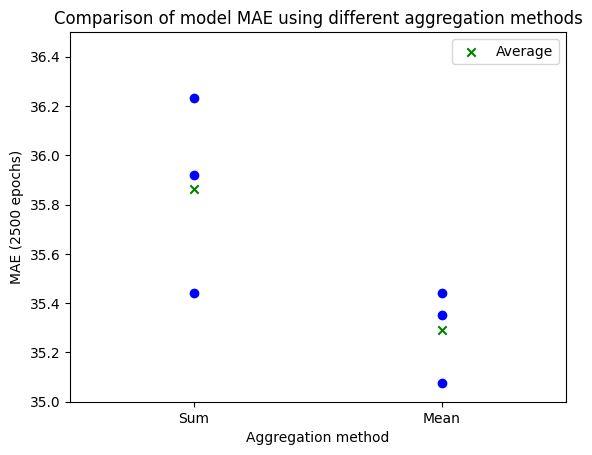

In [10]:
left_values = [35.4409, 36.2337, 35.9196]     
right_values = [35.0761, 35.3504, 35.4430]    

plt.scatter([1]*len(left_values), left_values, color="blue")
plt.scatter([2]*len(right_values), right_values, color="blue")

plt.scatter([1,2], [sum(left_values) / len(left_values), sum(right_values) / len(right_values)], color="green", marker="x", label="Average")

plt.title("Comparison of model MAE using different aggregation methods")
plt.ylabel("MAE (2500 epochs)")
plt.xlabel("Aggregation method")
plt.xticks([1, 2], ["Sum", "Mean"])
plt.legend()

plt.xlim(0.5, 2.5)
plt.ylim(35, 36.5)
plt.show()


##### Comparison of model MAE after adding clipping

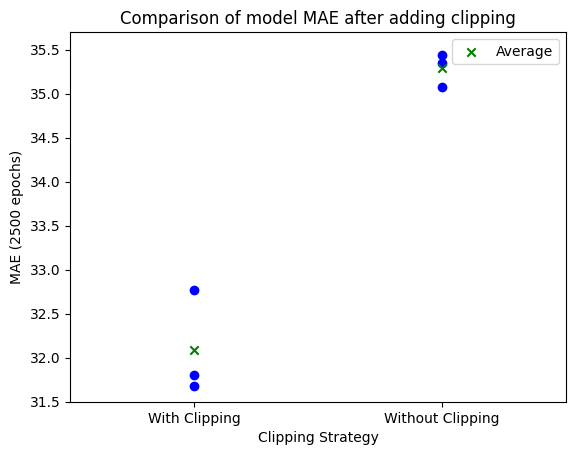

In [11]:
left_values = [32.7731, 31.8037, 31.6742]      
right_values = [35.0761, 35.3504, 35.4430]    

plt.scatter([1]*len(left_values), left_values, color="blue")
plt.scatter([2]*len(right_values), right_values, color="blue")

plt.scatter([1,2], [sum(left_values) / len(left_values), sum(right_values) / len(right_values)], color="green", marker="x", label="Average")

plt.title("Comparison of model MAE after adding clipping")
plt.ylabel("MAE (2500 epochs)")
plt.xlabel("Clipping Strategy")
plt.xticks([1, 2], ["With Clipping", "Without Clipping"])
plt.legend()

plt.xlim(0.5, 2.5)
plt.ylim(31.5, 35.7)
plt.show()

##### Comparison of model MAE using different validation methods

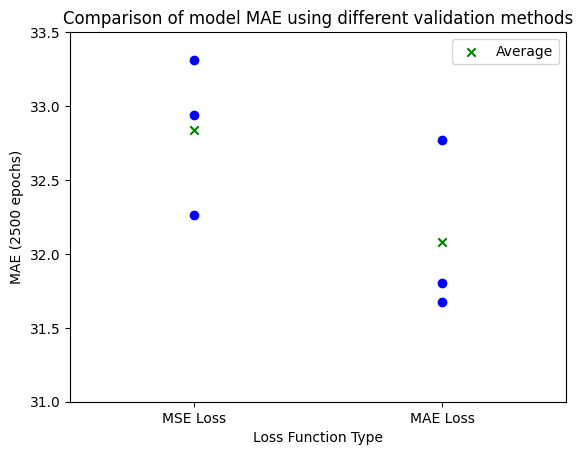

In [13]:
left_values = [32.2627, 33.3119, 32.9418]     
right_values = [32.7731, 31.8037, 31.6742]    

plt.scatter([1]*len(left_values), left_values, color="blue")
plt.scatter([2]*len(right_values), right_values, color="blue")

plt.scatter([1,2], [sum(left_values) / len(left_values), sum(right_values) / len(right_values)], color="green", marker="x", label="Average")

plt.title("Comparison of model MAE using different validation methods")
plt.ylabel("MAE (2500 epochs)")
plt.xlabel("Loss Function Type")
plt.xticks([1, 2], ["MSE Loss", "MAE Loss"])
plt.legend()

plt.xlim(0.5, 2.5)
plt.ylim(31, 33.5)
plt.show()


##### Comparison of model MAE using different hidden dimensions

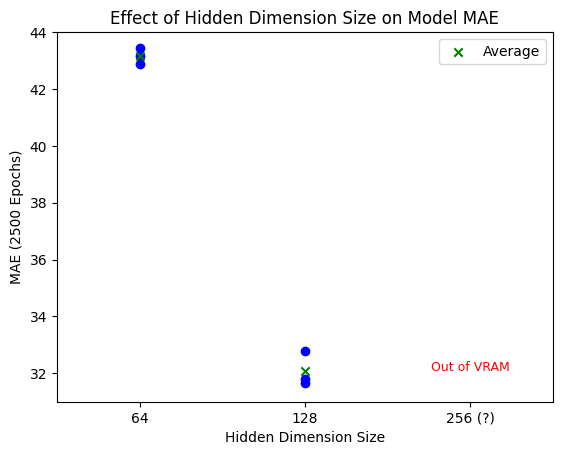

In [14]:
values_64  = [42.8819, 43.1476, 43.4429]
values_128 = [32.7731, 31.8037, 31.6742]
values_256 = []  # No values due to VRAM limitation


plt.scatter([1]*len(values_64), values_64, color="blue")
plt.scatter([2]*len(values_128), values_128, color="blue")

plt.scatter(
    [1, 2],
    [
        sum(values_64) / len(values_64),
        sum(values_128) / len(values_128)
    ],
    color="green",
    marker="x",
    label="Average"
)

plt.title("Effect of Hidden Dimension Size on Model MAE")
plt.ylabel("MAE (2500 Epochs)")
plt.xlabel("Hidden Dimension Size")

plt.xticks(
    [1, 2, 3],
    ["64", "128", "256 (?)"]
)

plt.legend()

plt.xlim(0.5, 3.5)
plt.ylim(31, 44)

plt.text(
    3, 32.2,
    "Out of VRAM",
    ha="center",
    va="center",
    fontsize=9,
    color="red"
)

plt.show()


##### Comparison of model MAE using different numbers of hidden layers

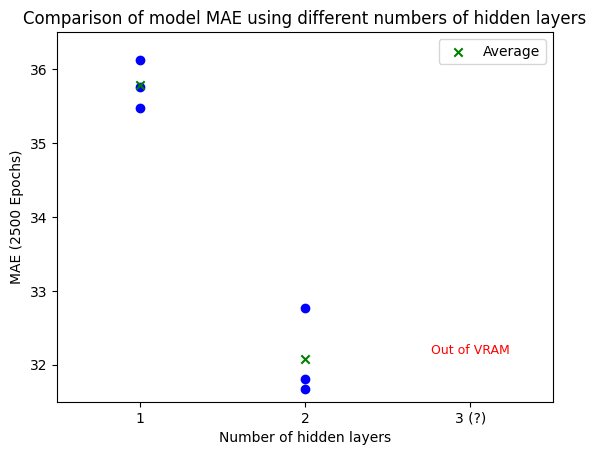

In [15]:
values_1  = [35.4716, 36.1243, 35.7632]
values_2 = [32.7731, 31.8037, 31.6742]
values_3 = []  # No values due to VRAM limitation


plt.scatter([1]*len(values_1), values_1, color="blue")
plt.scatter([2]*len(values_2), values_2, color="blue")

plt.scatter(
    [1, 2],
    [
        sum(values_1) / len(values_1),
        sum(values_2) / len(values_2)
    ],
    color="green",
    marker="x",
    label="Average"
)

plt.title("Comparison of model MAE using different numbers of hidden layers")
plt.ylabel("MAE (2500 Epochs)")
plt.xlabel("Number of hidden layers")

plt.xticks(
    [1, 2, 3],
    ["1", "2", "3 (?)"]
)

plt.legend()

plt.xlim(0.5, 3.5)
plt.ylim(31.5, 36.5)

plt.text(
    3, 32.2,
    "Out of VRAM",
    ha="center",
    va="center",
    fontsize=9,
    color="red"
)

plt.show()

##### Comparison of model MAE using different dropout

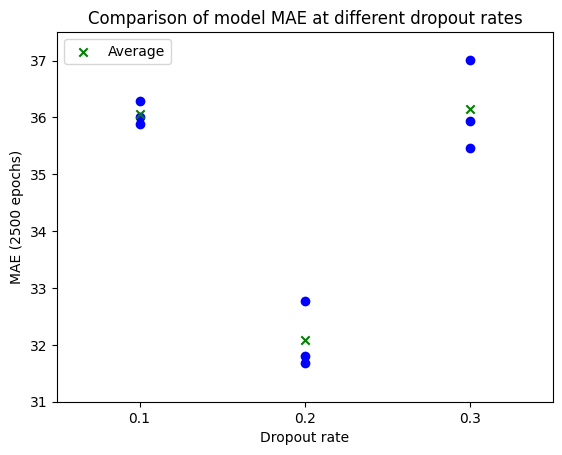

In [16]:
left_values = [35.8790, 36.0019, 36.2928]
middle_values = [32.7731, 31.8037, 31.6742]
right_values = [37.0068, 35.4680, 35.9446]

plt.scatter([1]*len(left_values), left_values, color="blue")
plt.scatter([2]*len(middle_values), middle_values, color="blue")
plt.scatter([3]*len(right_values), right_values, color="blue")

plt.scatter(
    [1, 2, 3],
    [
        sum(left_values) / len(left_values),
        sum(middle_values) / len(middle_values),
        sum(right_values) / len(right_values)
    ],
    color="green",
    marker="x",
    label="Average"
)

plt.title("Comparison of model MAE at different dropout rates")
plt.ylabel("MAE (2500 epochs)")
plt.xlabel("Dropout rate")
plt.xticks([1, 2, 3], ["0.1", "0.2", "0.3"])
plt.legend()

plt.xlim(0.5, 3.5)
plt.ylim(31, 37.5)
plt.show()

##### Comparison of model MAE at different epochs

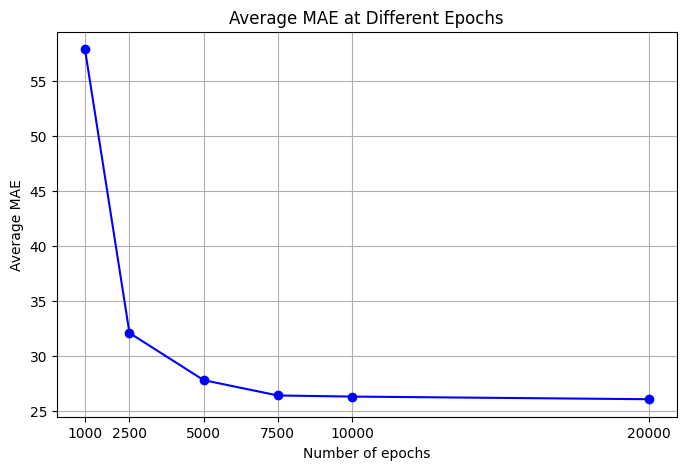

In [17]:
epochs = [1000, 2500, 5000, 7500, 10000, 20000]
avg_mae = [57.8735, 32.0837, 27.7948, 26.4016, 26.3001, 26.0595]

plt.figure(figsize=(8,5))
plt.plot(epochs, avg_mae, marker='o', color='blue')
plt.xlabel("Number of epochs")
plt.ylabel("Average MAE")
plt.title("Average MAE at Different Epochs")
plt.xticks(epochs)
plt.grid(True)
plt.show()

##### Graph of validation and training MAE trough epochs 

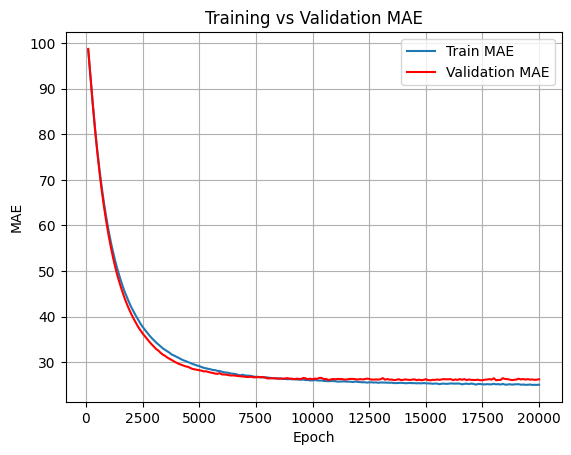

In [18]:
import re
text="""
Epoch: 100, Loss: 98.5265, Val Loss: 98.7454, R2: -0.1317
Epoch: 200, Loss: 92.6798, Val Loss: 92.7326, R2: -0.0944
Epoch: 300, Loss: 86.7953, Val Loss: 86.7052, R2: -0.0527
Epoch: 400, Loss: 81.3690, Val Loss: 81.1538, R2: -0.0086
Epoch: 500, Loss: 76.5129, Val Loss: 76.1403, R2: 0.0355
Epoch: 600, Loss: 72.1702, Val Loss: 71.6307, R2: 0.0795
Epoch: 700, Loss: 68.2846, Val Loss: 67.5901, R2: 0.1219
Epoch: 800, Loss: 64.7861, Val Loss: 63.9989, R2: 0.1622
Epoch: 900, Loss: 61.6998, Val Loss: 60.7471, R2: 0.2011
Epoch: 1000, Loss: 58.8566, Val Loss: 57.8419, R2: 0.2375
Epoch: 1100, Loss: 56.3223, Val Loss: 55.2223, R2: 0.2724
Epoch: 1200, Loss: 54.0922, Val Loss: 52.8508, R2: 0.3051
Epoch: 1300, Loss: 52.0406, Val Loss: 50.7192, R2: 0.3352
Epoch: 1400, Loss: 50.2173, Val Loss: 48.8030, R2: 0.3635
Epoch: 1500, Loss: 48.5406, Val Loss: 47.1433, R2: 0.3898
Epoch: 1600, Loss: 46.9802, Val Loss: 45.5803, R2: 0.4144
Epoch: 1700, Loss: 45.5697, Val Loss: 44.1395, R2: 0.4379
Epoch: 1800, Loss: 44.3554, Val Loss: 42.8359, R2: 0.4598
Epoch: 1900, Loss: 43.1659, Val Loss: 41.6393, R2: 0.4806
Epoch: 2000, Loss: 42.0580, Val Loss: 40.5726, R2: 0.4996
Epoch: 2100, Loss: 41.1109, Val Loss: 39.5749, R2: 0.5179
Epoch: 2200, Loss: 40.2135, Val Loss: 38.6864, R2: 0.5348
Epoch: 2300, Loss: 39.3373, Val Loss: 37.7722, R2: 0.5510
Epoch: 2400, Loss: 38.4997, Val Loss: 37.0172, R2: 0.5673
Epoch: 2500, Loss: 37.7402, Val Loss: 36.3070, R2: 0.5812
Epoch: 2600, Loss: 37.1090, Val Loss: 35.6906, R2: 0.5948
Epoch: 2700, Loss: 36.4569, Val Loss: 35.0672, R2: 0.6074
Epoch: 2800, Loss: 35.8578, Val Loss: 34.4699, R2: 0.6197
Epoch: 2900, Loss: 35.2897, Val Loss: 33.9083, R2: 0.6314
Epoch: 3000, Loss: 34.7960, Val Loss: 33.4023, R2: 0.6426
Epoch: 3100, Loss: 34.2912, Val Loss: 32.8702, R2: 0.6531
Epoch: 3200, Loss: 33.8475, Val Loss: 32.5114, R2: 0.6625
Epoch: 3300, Loss: 33.4301, Val Loss: 32.0160, R2: 0.6718
Epoch: 3400, Loss: 32.9983, Val Loss: 31.6281, R2: 0.6804
Epoch: 3500, Loss: 32.6639, Val Loss: 31.3491, R2: 0.6878
Epoch: 3600, Loss: 32.3462, Val Loss: 30.9732, R2: 0.6958
Epoch: 3700, Loss: 32.0178, Val Loss: 30.7100, R2: 0.7029
Epoch: 3800, Loss: 31.6301, Val Loss: 30.4227, R2: 0.7095
Epoch: 3900, Loss: 31.4247, Val Loss: 30.1134, R2: 0.7162
Epoch: 4000, Loss: 31.1502, Val Loss: 29.8632, R2: 0.7227
Epoch: 4100, Loss: 30.9179, Val Loss: 29.6083, R2: 0.7282
Epoch: 4200, Loss: 30.6330, Val Loss: 29.4177, R2: 0.7334
Epoch: 4300, Loss: 30.3998, Val Loss: 29.2065, R2: 0.7389
Epoch: 4400, Loss: 30.2383, Val Loss: 29.0607, R2: 0.7438
Epoch: 4500, Loss: 30.0091, Val Loss: 28.9669, R2: 0.7473
Epoch: 4600, Loss: 29.8291, Val Loss: 28.7498, R2: 0.7509
Epoch: 4700, Loss: 29.5958, Val Loss: 28.5130, R2: 0.7571
Epoch: 4800, Loss: 29.4440, Val Loss: 28.4064, R2: 0.7611
Epoch: 4900, Loss: 29.2561, Val Loss: 28.2952, R2: 0.7640
Epoch: 5000, Loss: 29.1230, Val Loss: 28.2128, R2: 0.7677
Epoch: 5100, Loss: 28.9164, Val Loss: 28.1211, R2: 0.7705
Epoch: 5200, Loss: 28.7452, Val Loss: 27.9606, R2: 0.7737
Epoch: 5300, Loss: 28.6451, Val Loss: 27.9904, R2: 0.7763
Epoch: 5400, Loss: 28.5247, Val Loss: 27.8424, R2: 0.7791
Epoch: 5500, Loss: 28.4185, Val Loss: 27.7035, R2: 0.7825
Epoch: 5600, Loss: 28.2814, Val Loss: 27.6300, R2: 0.7848
Epoch: 5700, Loss: 28.2354, Val Loss: 27.4750, R2: 0.7895
Epoch: 5800, Loss: 28.0827, Val Loss: 27.4358, R2: 0.7909
Epoch: 5900, Loss: 28.0410, Val Loss: 27.5751, R2: 0.7913
Epoch: 6000, Loss: 27.8771, Val Loss: 27.2974, R2: 0.7956
Epoch: 6100, Loss: 27.7558, Val Loss: 27.2885, R2: 0.7973
Epoch: 6200, Loss: 27.7062, Val Loss: 27.2498, R2: 0.7991
Epoch: 6300, Loss: 27.6459, Val Loss: 27.1278, R2: 0.8015
Epoch: 6400, Loss: 27.4923, Val Loss: 27.0609, R2: 0.8043
Epoch: 6500, Loss: 27.4485, Val Loss: 27.0855, R2: 0.8046
Epoch: 6600, Loss: 27.3776, Val Loss: 27.0392, R2: 0.8061
Epoch: 6700, Loss: 27.2434, Val Loss: 26.9437, R2: 0.8072
Epoch: 6800, Loss: 27.0931, Val Loss: 26.9092, R2: 0.8099
Epoch: 6900, Loss: 27.2246, Val Loss: 26.8649, R2: 0.8119
Epoch: 7000, Loss: 27.0935, Val Loss: 26.7930, R2: 0.8126
Epoch: 7100, Loss: 27.0411, Val Loss: 26.7298, R2: 0.8152
Epoch: 7200, Loss: 27.0239, Val Loss: 26.7494, R2: 0.8156
Epoch: 7300, Loss: 26.9585, Val Loss: 26.7927, R2: 0.8167
Epoch: 7400, Loss: 26.8153, Val Loss: 26.6525, R2: 0.8191
Epoch: 7500, Loss: 26.7705, Val Loss: 26.6694, R2: 0.8198
Epoch: 7600, Loss: 26.7759, Val Loss: 26.6807, R2: 0.8204
Epoch: 7700, Loss: 26.6501, Val Loss: 26.7024, R2: 0.8216
Epoch: 7800, Loss: 26.6292, Val Loss: 26.7301, R2: 0.8225
Epoch: 7900, Loss: 26.6659, Val Loss: 26.6162, R2: 0.8240
Epoch: 8000, Loss: 26.6372, Val Loss: 26.4310, R2: 0.8264
Epoch: 8100, Loss: 26.5480, Val Loss: 26.4231, R2: 0.8270
Epoch: 8200, Loss: 26.5097, Val Loss: 26.4618, R2: 0.8268
Epoch: 8300, Loss: 26.4279, Val Loss: 26.4621, R2: 0.8279
Epoch: 8400, Loss: 26.4627, Val Loss: 26.3955, R2: 0.8295
Epoch: 8500, Loss: 26.3965, Val Loss: 26.3675, R2: 0.8308
Epoch: 8600, Loss: 26.4029, Val Loss: 26.3927, R2: 0.8311
Epoch: 8700, Loss: 26.2936, Val Loss: 26.3673, R2: 0.8317
Epoch: 8800, Loss: 26.3051, Val Loss: 26.4281, R2: 0.8323
Epoch: 8900, Loss: 26.2404, Val Loss: 26.4743, R2: 0.8324
Epoch: 9000, Loss: 26.2824, Val Loss: 26.3611, R2: 0.8343
Epoch: 9100, Loss: 26.2273, Val Loss: 26.3666, R2: 0.8340
Epoch: 9200, Loss: 26.2382, Val Loss: 26.2494, R2: 0.8362
Epoch: 9300, Loss: 26.1844, Val Loss: 26.3599, R2: 0.8361
Epoch: 9400, Loss: 26.1431, Val Loss: 26.3145, R2: 0.8365
Epoch: 9500, Loss: 26.1359, Val Loss: 26.3020, R2: 0.8368
Epoch: 9600, Loss: 26.1744, Val Loss: 26.5328, R2: 0.8364
Epoch: 9700, Loss: 26.0443, Val Loss: 26.4208, R2: 0.8376
Epoch: 9800, Loss: 26.0695, Val Loss: 26.2365, R2: 0.8374
Epoch: 9900, Loss: 25.9776, Val Loss: 26.3613, R2: 0.8386
Epoch: 10000, Loss: 25.9912, Val Loss: 26.2481, R2: 0.8402
Epoch: 10100, Loss: 26.0620, Val Loss: 26.3914, R2: 0.8403
Epoch: 10200, Loss: 25.9830, Val Loss: 26.3104, R2: 0.8369
Epoch: 10300, Loss: 25.9468, Val Loss: 26.5338, R2: 0.8398
Epoch: 10400, Loss: 25.9580, Val Loss: 26.5280, R2: 0.8403
Epoch: 10500, Loss: 25.8698, Val Loss: 26.2474, R2: 0.8432
Epoch: 10600, Loss: 25.8453, Val Loss: 26.3142, R2: 0.8424
Epoch: 10700, Loss: 25.8044, Val Loss: 26.0818, R2: 0.8447
Epoch: 10800, Loss: 25.8446, Val Loss: 26.1725, R2: 0.8451
Epoch: 10900, Loss: 25.8239, Val Loss: 26.3005, R2: 0.8443
Epoch: 11000, Loss: 25.8138, Val Loss: 26.2212, R2: 0.8454
Epoch: 11100, Loss: 25.7110, Val Loss: 26.2942, R2: 0.8447
Epoch: 11200, Loss: 25.7307, Val Loss: 26.2993, R2: 0.8451
Epoch: 11300, Loss: 25.7617, Val Loss: 26.2842, R2: 0.8462
Epoch: 11400, Loss: 25.7653, Val Loss: 26.1733, R2: 0.8468
Epoch: 11500, Loss: 25.7115, Val Loss: 26.1806, R2: 0.8474
Epoch: 11600, Loss: 25.7183, Val Loss: 26.2904, R2: 0.8468
Epoch: 11700, Loss: 25.6803, Val Loss: 26.3158, R2: 0.8477
Epoch: 11800, Loss: 25.6373, Val Loss: 26.3008, R2: 0.8473
Epoch: 11900, Loss: 25.7338, Val Loss: 26.2373, R2: 0.8458
Epoch: 12000, Loss: 25.6609, Val Loss: 26.1743, R2: 0.8486
Epoch: 12100, Loss: 25.6237, Val Loss: 26.2738, R2: 0.8486
Epoch: 12200, Loss: 25.5692, Val Loss: 26.1900, R2: 0.8493
Epoch: 12300, Loss: 25.5831, Val Loss: 26.2610, R2: 0.8488
Epoch: 12400, Loss: 25.4985, Val Loss: 26.3721, R2: 0.8503
Epoch: 12500, Loss: 25.5712, Val Loss: 26.3072, R2: 0.8496
Epoch: 12600, Loss: 25.5637, Val Loss: 26.1684, R2: 0.8499
Epoch: 12700, Loss: 25.5124, Val Loss: 26.1625, R2: 0.8515
Epoch: 12800, Loss: 25.5547, Val Loss: 26.2042, R2: 0.8509
Epoch: 12900, Loss: 25.4599, Val Loss: 26.1617, R2: 0.8519
Epoch: 13000, Loss: 25.5262, Val Loss: 26.2335, R2: 0.8475
Epoch: 13100, Loss: 25.5264, Val Loss: 26.4856, R2: 0.8487
Epoch: 13200, Loss: 25.5005, Val Loss: 26.1442, R2: 0.8528
Epoch: 13300, Loss: 25.4851, Val Loss: 26.2823, R2: 0.8505
Epoch: 13400, Loss: 25.4676, Val Loss: 26.1425, R2: 0.8526
Epoch: 13500, Loss: 25.4855, Val Loss: 26.1804, R2: 0.8529
Epoch: 13600, Loss: 25.3953, Val Loss: 26.0458, R2: 0.8537
Epoch: 13700, Loss: 25.3974, Val Loss: 26.1112, R2: 0.8524
Epoch: 13800, Loss: 25.4380, Val Loss: 26.2454, R2: 0.8527
Epoch: 13900, Loss: 25.4591, Val Loss: 26.0681, R2: 0.8537
Epoch: 14000, Loss: 25.4248, Val Loss: 26.1083, R2: 0.8540
Epoch: 14100, Loss: 25.3623, Val Loss: 26.2071, R2: 0.8525
Epoch: 14200, Loss: 25.3973, Val Loss: 26.1246, R2: 0.8538
Epoch: 14300, Loss: 25.4231, Val Loss: 26.0842, R2: 0.8537
Epoch: 14400, Loss: 25.3845, Val Loss: 26.1643, R2: 0.8543
Epoch: 14500, Loss: 25.3861, Val Loss: 26.2161, R2: 0.8535
Epoch: 14600, Loss: 25.3388, Val Loss: 26.0252, R2: 0.8554
Epoch: 14700, Loss: 25.3696, Val Loss: 26.1577, R2: 0.8549
Epoch: 14800, Loss: 25.3335, Val Loss: 26.0184, R2: 0.8548
Epoch: 14900, Loss: 25.4039, Val Loss: 26.1078, R2: 0.8552
Epoch: 15000, Loss: 25.3397, Val Loss: 26.2411, R2: 0.8538
Epoch: 15100, Loss: 25.3168, Val Loss: 26.0571, R2: 0.8557
Epoch: 15200, Loss: 25.3114, Val Loss: 26.0118, R2: 0.8556
Epoch: 15300, Loss: 25.2456, Val Loss: 26.1124, R2: 0.8555
Epoch: 15400, Loss: 25.2975, Val Loss: 26.0899, R2: 0.8559
Epoch: 15500, Loss: 25.2860, Val Loss: 26.1883, R2: 0.8551
Epoch: 15600, Loss: 25.1588, Val Loss: 26.1060, R2: 0.8560
Epoch: 15700, Loss: 25.2614, Val Loss: 26.1984, R2: 0.8557
Epoch: 15800, Loss: 25.2764, Val Loss: 26.2627, R2: 0.8545
Epoch: 15900, Loss: 25.2258, Val Loss: 26.2266, R2: 0.8558
Epoch: 16000, Loss: 25.2502, Val Loss: 26.2315, R2: 0.8555
Epoch: 16100, Loss: 25.3211, Val Loss: 26.2624, R2: 0.8541
Epoch: 16200, Loss: 25.2982, Val Loss: 26.0441, R2: 0.8566
Epoch: 16300, Loss: 25.2742, Val Loss: 26.2057, R2: 0.8562
Epoch: 16400, Loss: 25.2965, Val Loss: 26.0875, R2: 0.8575
Epoch: 16500, Loss: 25.2844, Val Loss: 26.2717, R2: 0.8557
Epoch: 16600, Loss: 25.1146, Val Loss: 26.1184, R2: 0.8567
Epoch: 16700, Loss: 25.2265, Val Loss: 26.2733, R2: 0.8561
Epoch: 16800, Loss: 25.2679, Val Loss: 26.0549, R2: 0.8568
Epoch: 16900, Loss: 25.1876, Val Loss: 26.1887, R2: 0.8561
Epoch: 17000, Loss: 25.2847, Val Loss: 26.1002, R2: 0.8557
Epoch: 17100, Loss: 25.2281, Val Loss: 26.0860, R2: 0.8577
Epoch: 17200, Loss: 25.0583, Val Loss: 26.0789, R2: 0.8579
Epoch: 17300, Loss: 25.1930, Val Loss: 26.1455, R2: 0.8565
Epoch: 17400, Loss: 25.2068, Val Loss: 26.0063, R2: 0.8585
Epoch: 17500, Loss: 25.1224, Val Loss: 26.0429, R2: 0.8558
Epoch: 17600, Loss: 25.1061, Val Loss: 26.1309, R2: 0.8574
Epoch: 17700, Loss: 25.1642, Val Loss: 26.1741, R2: 0.8557
Epoch: 17800, Loss: 25.1266, Val Loss: 26.2676, R2: 0.8564
Epoch: 17900, Loss: 25.1194, Val Loss: 26.1449, R2: 0.8568
Epoch: 18000, Loss: 25.2350, Val Loss: 26.4555, R2: 0.8553
Epoch: 18100, Loss: 25.1105, Val Loss: 26.0278, R2: 0.8583
Epoch: 18200, Loss: 25.1700, Val Loss: 26.0887, R2: 0.8574
Epoch: 18300, Loss: 25.0815, Val Loss: 26.0903, R2: 0.8575
Epoch: 18400, Loss: 25.2103, Val Loss: 26.4732, R2: 0.8541
Epoch: 18500, Loss: 25.0541, Val Loss: 26.2867, R2: 0.8559
Epoch: 18600, Loss: 25.0683, Val Loss: 26.2709, R2: 0.8565
Epoch: 18700, Loss: 25.1455, Val Loss: 26.1544, R2: 0.8571
Epoch: 18800, Loss: 25.0591, Val Loss: 26.0519, R2: 0.8586
Epoch: 18900, Loss: 25.1073, Val Loss: 26.1063, R2: 0.8582
Epoch: 19000, Loss: 25.1406, Val Loss: 26.1811, R2: 0.8570
Epoch: 19100, Loss: 25.1480, Val Loss: 26.3607, R2: 0.8545
Epoch: 19200, Loss: 25.0387, Val Loss: 26.1975, R2: 0.8569
Epoch: 19300, Loss: 25.0850, Val Loss: 26.2797, R2: 0.8568
Epoch: 19400, Loss: 25.0125, Val Loss: 26.1684, R2: 0.8578
Epoch: 19500, Loss: 25.0287, Val Loss: 26.2605, R2: 0.8565
Epoch: 19600, Loss: 25.0815, Val Loss: 26.1617, R2: 0.8574
Epoch: 19700, Loss: 24.9928, Val Loss: 26.1962, R2: 0.8574
Epoch: 19800, Loss: 25.0141, Val Loss: 26.1097, R2: 0.8580
Epoch: 19900, Loss: 25.0020, Val Loss: 26.1470, R2: 0.8587
Epoch: 20000, Loss: 25.0508, Val Loss: 26.2262, R2: 0.8574
"""
epochs = []
train_mae = []
val_mae = []

pattern = r"Epoch:\s*(\d+),\s*Loss:\s*([\d.]+),\s*Val Loss:\s*([\d.]+)"

for line in text.splitlines():
    match = re.search(pattern, line)
    if match:
        epochs.append(int(match.group(1)))
        train_mae.append(float(match.group(2)))
        val_mae.append(float(match.group(3)))


plt.figure()
plt.plot(epochs, train_mae)  
plt.plot(epochs, val_mae, color="red")  

plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training vs Validation MAE")
plt.legend(["Train MAE", "Validation MAE"])
plt.grid(True)

plt.show()
